In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sci_mplstyle_package

# Define spatial basis function
def phi_k(x, k):
    return np.sqrt(2) * np.sin(k * np.pi * x)


# Define modal coefficients (ai) based on the given formula
def a_i(i, s, ep, tau, T, c_v, c_m, t, omega, k_range):

    omega_i = (np.pi*i)**2
    
    # Define Cik and Dik constants based on dk, ak, and ci
    def CDi_k(dk, ak, fi, omega, ci, k):

        Ci_k = (dk * ak * fi) / ((k * ci * omega)**2 + ak**2)
        Di_k = (k * dk * omega * ci * fi) / ((k * ci * omega)**2 + ak**2)

        return Ci_k, Di_k


    # Define dk based on the given cases
    def d_k(k, T, tau):
        if T == k * tau:
            return (-1)**k / T
        else:
            return (2 * (T**3 * np.cos(np.pi * k) * np.sin(np.pi * k * tau / T))) / \
                (T * (np.pi * k * tau * T**2 - np.pi * k**3 * tau**3))


    # Define fi integral
    def f_i(i, ep, s):
        if i*ep == 2:
            return (1 / np.sqrt(2)) * np.sin(i *s* np.pi)
        else:
            return (8 * np.sqrt(2) * np.sin(i * s * np.pi) * np.sin(i * np.pi * ep / 2)) / (4 * np.pi * i * ep - i**3 * ep**3 * np.pi)


    # Define ci based on the formula
    def c_i(omega_i, c_v, c_m):
        return c_v + c_m * omega_i**2


    # Update alpha_k definition based on the new formula
    def alpha_k(omega_i, k, omega):
        return omega_i**2 - (k * omega)**2
    
    
    dk = [d_k(k+1, T, tau) for k in k_range]
    alphak =  [alpha_k(omega_i, k+1, omega) for k in k_range]


    ci = c_i(omega_i, c_v, c_m)
    fi = f_i(i, ep, s)

    sum_term_d = 0
    sum_term_v = 0


    for k in k_range:
        
        Ci_k, Di_k = CDi_k(dk[k], alphak[k], fi, omega, ci, k)

        sum_term_d += Ci_k * np.cos((k+1) * omega * t)     +     Di_k * np.sin((k+1) * omega * t)

        sum_term_v += (-(k+1) * omega) * Ci_k * np.sin((k+1) * omega * t)    +   ((k+1) * omega) * Di_k * np.cos((k+1) * omega * t)


    return (fi / (omega_i**2 * T)) + sum_term_d, sum_term_v


Duplicate key in file 'c:\\Users\\suparnob\\AppData\\Local\\anaconda3\\Lib\\site-packages\\sci_mplstyle_package\\style_files\\publication.mplstyle', line 64 ('axes.axisbelow : True')


In [ ]:
T = 2 / (2 * np.pi)  # Period of the vibration
s_param = (-2**(-0.5)+0.5, 0.0) # For F
tau_param = (T/20, T/2) # For K

param_ranges = [tau_param, s_param]

In [ ]:
def generate_sobol(dimensions, num_points, bounds):
    """
    Generates a Sobol sequence.
    
    Parameters:
    dimensions (int): Number of dimensions in the Sobol sequence.
    num_points (int): Number of points in the sequence.
    bounds (list of tuples): A list of tuples containing the lower and upper bounds for each dimension.
    
    Returns:
    np.array: A numpy array containing the Sobol sequence scaled to the provided bounds.
    """
    from scipy.stats.qmc import Sobol

    sobol = Sobol(d=dimensions)
    samples = sobol.random_base2(m=int(np.log2(num_points)))
    scaled_samples = np.empty_like(samples)
    
    for i in range(dimensions):
        lower, upper = bounds[i]
        scaled_samples[:, i] = samples[:, i] * (upper - lower) + lower
        
    return scaled_samples

In [ ]:
uq_params = generate_sobol(len(param_ranges), 16, param_ranges)
print(uq_params)

In [15]:
# Parameters (adjust as needed)
i_range = range(1, 250)  # Mode numbers
k_range = range(0, 90)  # Fourier numbers

T = 1/np.pi  # Time period
omega = 2*np.pi/T # Forcing frequency

x = np.linspace(0, 1, 251)  # Spatial domain
t = np.linspace(0, 5*T, 5*200)  # Time domain

# ep = 0.02#2-2**0.5  # Some constant for fi
# tau = 0.07673#0.11068396#0.09505567#0.14829#    T/20  # Some constant for tau (adjust as needed)
# s = 0.61824407#0.67814419#0.5101752#1/2**0.5  #0.6992465#


ep = 0.02#2-2**0.5
tau = 0.001#(T/20 to T)
s=1/2**0.5

# delta s between 0.5, 1-s + hard cutoff so that s < 0.9
# s_new = delta s + 1/2**0.5

# Define constants c_v and c_m
c_v = 1.0  # Placeholder value, adjust as needed
c_m = 0.001 # Placeholder value, adjust as needed


W = 0
W_dot =  0

for i in i_range:

    ai,ai_dot = a_i(i, s, ep, tau, T, c_v, c_m, t, omega, k_range)
    phi_i= phi_k(x, i)

    W += phi_i.reshape(-1,1) @ ai.reshape(1,-1)
    W_dot += phi_i.reshape(-1,1) @ ai_dot.reshape(1,-1)


# Visualization of response
# X, T_vals = np.meshgrid(x, t)
# plt.contourf(T_vals, X, W.T, levels=100, cmap='RdBu')
# plt.colorbar(label='Beam response w(x,t)')
# plt.xlabel('Time t')
# plt.ylabel('Position x')
# plt.show()


In [3]:
W.shape

(251, 1000)

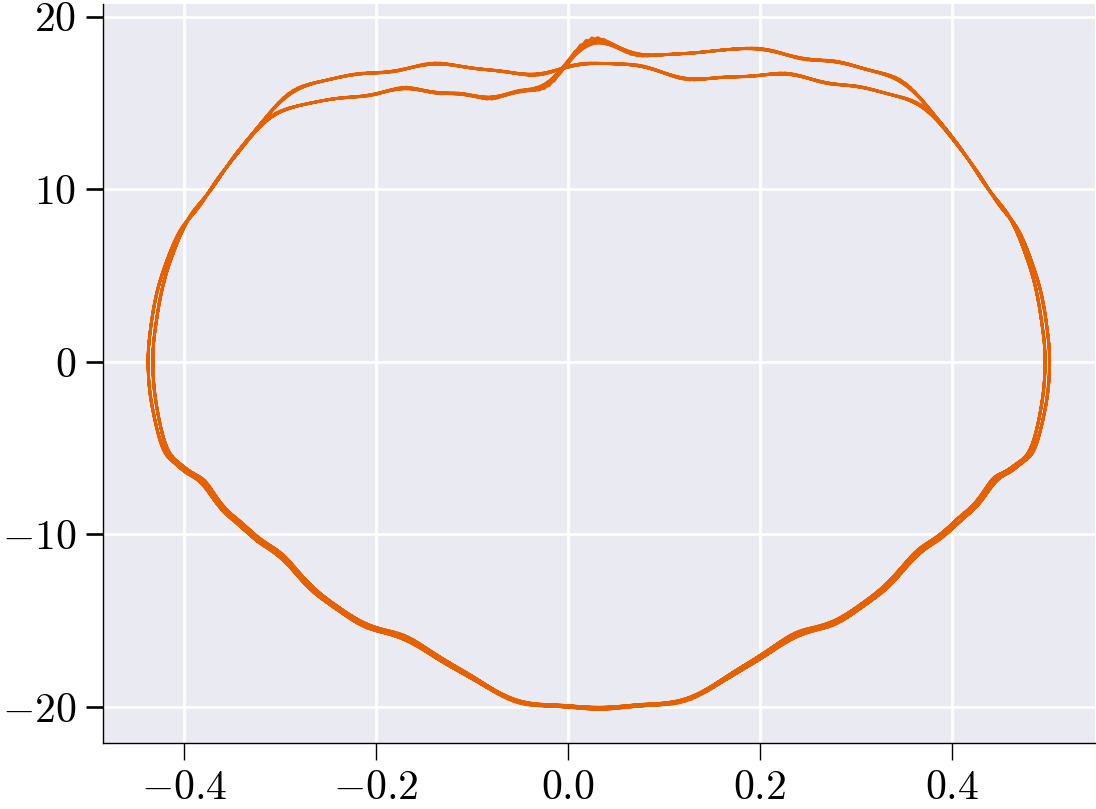

In [12]:
plt.plot(W[int(0.8*251)],W_dot[int(0.8*251)])